# 🎓 **Taller 4.3: Taller de Métodos de clustering basados en particiones Parte 2**


## OBJETIVOS DEL TALLER:
En esta práctica estudiaremos el funcionamiento y la utilización métodos de clustering basados en particiones, como el K-means y el K-medoids.

# 🔧 **CONFIGURACIÓN INICIAL**

In [92]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import itertools as it

from mpl_toolkits.mplot3d import Axes3D
from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs

plt.rcParams['figure.figsize'] = [8, 8]

# 📁 **CARGAR LOS DATASETS Y GRAFICAR SUS DISTRIBUCIONES**

In [93]:
# Cargar dataset artificial
def cargar_dataset(nombre_dataset):
    try:
        # Intentar cargar desde URL alternativa
        data_file_url = "https://raw.githubusercontent.com/SandraNavarrete-docente/aprendizaje-automatico-252601/main/04-MODELOS-NO-SUPERVISADOS/data/"+nombre_dataset
        D = np.array(pd.read_excel(data_file_url,header=0))
        print("✅ Dataset cargado desde URL GitHub")
        return D
    except:
        print("❌ No se pudo cargar el dataset")
        return None

✅ Dataset cargado desde URL GitHub


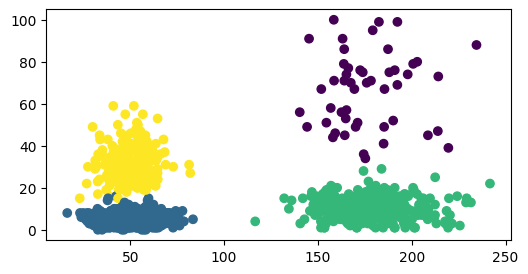

In [94]:
# Cargar dataset
D =cargar_dataset("dataset_cuatro_diferente_densidad.xlsx")
Dx = D[:,0:2]
Dy = D[:,2]
fig, ax = plt.subplots(figsize=(6,3))
ax.scatter(Dx[:,0],Dx[:,1], c=Dy)

# 🎯 **:Cree el algoritmo K-means que tiene un único parámetro: el número de clústeres (K).**

In [95]:
# PASO 1 elejir los centros iniciales de forma randomica
def random_sample_float(n, mi, ma):
    return (ma - mi) * np.random.random_sample(n) + mi

def paso1_elije_centros(K, Dx):
  cDx = np.zeros(K*Dx.shape[1])
  cDx.shape = (K,Dx.shape[1])
  # 1.1 Completa el codigo aqui
  x1 = random_sample_float(K, np.min(Dx[:,0]), np.max(Dx[:,0]))
  x2 = random_sample_float(K, np.min(Dx[:,1]), np.max(Dx[:,1]))
  cDx[:,0] = x1
  cDx[:,1] = x2
  return cDx


Los centros iniciales elegidos aleatoriamente son:
[[111.32703707  92.55874491]
 [ 81.57941529  10.65914551]
 [141.45860355  22.38467132]
 [238.36274068   8.40822556]]


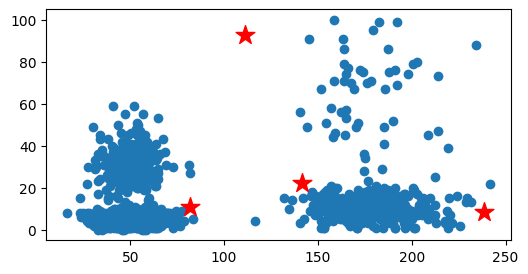

In [96]:
print('Los centros iniciales elegidos aleatoriamente son:')
K=4
cDx = paso1_elije_centros(K, Dx)
print(cDx)
fig, ax = plt.subplots(figsize=(6,3))
ax.scatter(Dx[:,0],Dx[:,1])
ax.scatter(cDx[:,0],cDx[:,1], marker='*', s=200, c='r')

2.   Paso de asignación de datos
En este paso, cada elemento de nuestro dataset se asigna al centroide más cercano basado en la distancia escogida: en nuestro caso, la Euclidiana. Por tanto, tendremos que implementar la siguiente operación:

$$
\DeclareMathOperator*{\argminA}{arg\,min}
\argminA_{c_i \in C} dist\left ( c_i, x \right )^2
$$

In [97]:
# Definimos la distancia euclidiana de una instancia x con respecto a un grupo de instancias C
def distancia_euclidiana_grupo(x, C):
  return np.linalg.norm(C - x, axis=1);

def paso2_asigna_puntos(Dx, cDx):
  Dyp = np.zeros(Dx.shape[0])
  # Buscamos el centro más cercano a cada instancia y la asignamos a ese clúster
  for i in np.arange(Dx.shape[0]):
      # Tenemos que calcular la distancia de cada muestra del dataset Dx[i]
      # a cada centro existente en cDx. Podemos utilizar para ello la función
      # distancia_euclidiana_grupo.

      distancia_punto_a_centros = distancia_euclidiana_grupo(Dx[i],cDx ) # 1.2 Completa el codigo aqui

      # Una vez calculada la distancia, necesitamos averiguar el índice de
      # la distancia mínima. Para ello, podemos usar la función argmin de numpy.
      pred_y = np.argmin(distancia_punto_a_centros)
      Dyp[i] = pred_y
  return Dyp

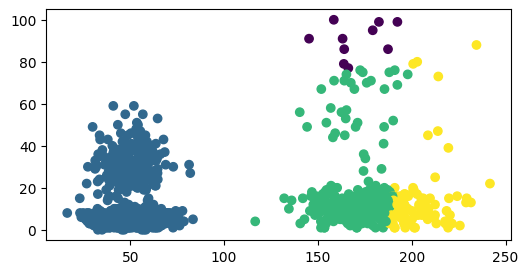

In [98]:
Dyp = paso2_asigna_puntos(Dx, cDx)
fig, ax = plt.subplots(figsize=(6,3))
ax.scatter(Dx[:,0],Dx[:,1], c=Dyp)

2.   Paso de actualización del centroide
En este paso se recalcula el centroide de cada cluster, teniendo en cuenta la nueva asignación calculada en el paso 1. Para ello, se calcula la media de todos los puntos asignados en el paso anterior.

$$
c_i = \frac{1}{\left | S_i \right |} \sum_{x_i \in S_i} x_i
$$


In [99]:
def paso3_actualiza_centros(Dx, cDx, Dyp, K):
  cDx_ant = cDx.copy()
  for k in range(K):
      # Seleccionamos los puntos asignados al cluster k
      puntos_cluster_k = Dx[Dyp == k]
      # Calculamos la media de las coordenadas x e y
      if len(puntos_cluster_k) > 0:  # Evitar división por cero si el cluster está vacío
          cDx[k,:] = np.mean(puntos_cluster_k, axis=0) # 1.3 Completa el codigo aqui
      else:
          # Si el cluster está vacío, mantenemos el centroide anterior
          cDx[k,:] = cDx_ant[k,:]
  return cDx

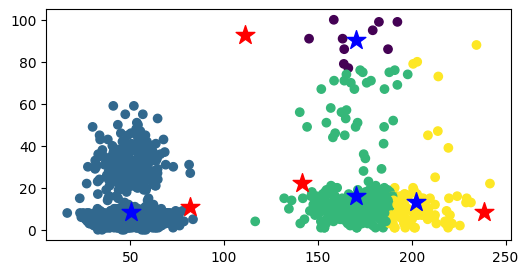

In [100]:
cDx_ant = cDx.copy()
cDx =paso3_actualiza_centros(Dx, cDx, Dyp, K)
fig, ax = plt.subplots(figsize=(6,3))
ax.scatter(Dx[:,0],Dx[:,1], c=Dyp)
ax.scatter(cDx[:,0],cDx[:,1], marker='*', s=200, c='b')
ax.scatter(cDx_ant[:,0],cDx_ant[:,1], marker='*', s=200, c='r')

Y esto es todo. Este proceso se repite hasta cumplir un criterio de detención:

*   No hay cambios en los puntos asignados a cada cluster
*   La suma de las distancias alcanza un valor mínimo establecido
*   Se alcanza un número máximo de iteraciones

In [101]:
def MyKMeans(Dx, K):
  cDx = paso1_elije_centros(K, Dx) # 1.4 Completa el codigo aqui
  cDxIni = cDx.copy()
  # Flag de convergencia
  iterando = True
  while iterando:
    # Vector auxiliar para guardar los centros de la iteración pasada
    # necesarios para identificar la convergencia
    cDx_ant = cDx.copy()
    Dyp = paso2_asigna_puntos(Dx, cDx) # 1.5 Completa el codigo aqui
    # Calcular los nuevos centros
    #cDx = # 1.6 Completa el codigo aqui
    cDx =paso3_actualiza_centros(Dx, cDx, Dyp, K)
    iterando = (np.absolute(np.sum(cDx-cDx_ant)) > 0.00001)
  return cDx, Dyp, cDxIni

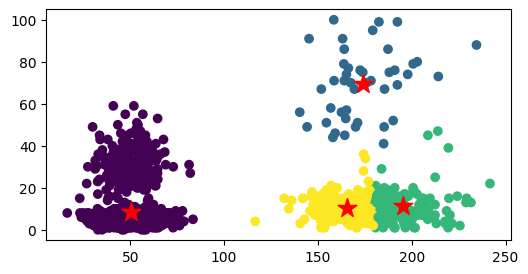

In [102]:
cDx, Dyp,cDxIni = MyKMeans(Dx, 4)
fig, ax = plt.subplots(figsize=(6,3))
ax.scatter(Dx[:,0],Dx[:,1], c=Dyp)
ax.scatter(cDx[:,0],cDx[:,1], marker='*', s=200, c='r')

# 🎯 **EJ 1: MODIFICA KMEANS PARA QUE SE CONVIERTA EN KMEANS++**

In [103]:
def distancia_euclidiana(a, b):
  return np.sqrt(np.sum((a - b) ** 2, axis=1))

def paso1_elije_centros_inteligente(K, Dx):
  cDx = np.zeros(K*Dx.shape[1])
  cDx.shape = (K,Dx.shape[1])

  # Paso 1: Primer centroide aleatorio,se elige aleatoriamente
  #        un punto de datos como primer centroide.
  n_samples, n_features = Dx.shape
  first_idx = np.random.randint(n_samples)
  cDx[0] = Dx[first_idx]

  # Pasos 2-4: Elegir centroides restantes
  for k in range(1, K):
      # Calcular distancias al centroide más cercano
      distances = np.zeros(n_samples)
      for i in range(n_samples):
          # Distancias del punto i a todos los centroides existentes
          point = Dx[i]
          dist_to_centroids = distancia_euclidiana(
              cDx[:k],
              np.tile(point, (k, 1))
          )
          # Guardar la distancia mínima
          distances[i] = np.min(dist_to_centroids)
      # Convertir distancias a probabilidades
      probabilities = distances ** 2
      probabilities /= probabilities.sum()

      # Elegir siguiente centroide basado en probabilidades
      next_idx = np.random.choice(n_samples, p=probabilities)
      cDx[k] = Dx[next_idx]
  return cDx

In [104]:
def MyKMeansPlusPlus(Dx, K):
  cDx = paso1_elije_centros(K, Dx)
  # 1.3 Completa el codigo aqui
  cDxIni = cDx.copy()
  # Flag de convergencia
  iterando = True
  while iterando:
    # Vector auxiliar para guardar los centros de la iteración pasada
    # necesarios para identificar la convergencia
    cDx_ant = cDx.copy()
    Dyp = paso2_asigna_puntos(Dx ,cDx)
    # 1.4 Completa el codigo aqui
    # Calcular los nuevos centros
    cDx = paso3_actualiza_centros(Dx, cDx, Dyp, K) # 1.5 Completa el codigo aqui
    iterando = (np.absolute(np.sum(cDx-cDx_ant)) > 0.00001)
  return cDx, Dyp, cDxIni

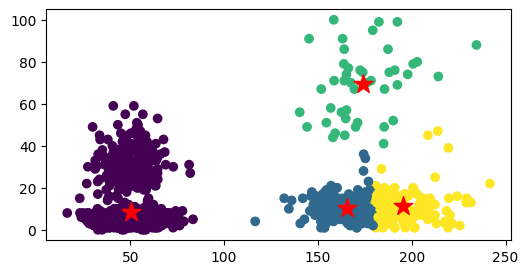

In [105]:
cDx, Dyp,cDxIni = MyKMeansPlusPlus(Dx, 4)
fig, ax = plt.subplots(figsize=(6,3))
ax.scatter(Dx[:,0],Dx[:,1], c=Dyp)
ax.scatter(cDx[:,0],cDx[:,1], marker='*', s=200, c='r')

# 🎯 **EJ 2: USA EL METODO DEL CODO CON KMEANS++ PARA DETERMINAR EL MEJOR K**
<hr>
<h2>Elegir el mejor valor de K</h2>

Para elegir el mejor valor de K se suele usar la técnica del codo. Ésta consiste en probar diferentes valores de K y evaluar el agrupamientos según alguna medida de evaluación intrínseca (ya que se supone que no se conoce la verdad básica). En este ejemplo, se usan dos medidas diferentes: la medida de Silueta y la R cuadrado.


In [20]:
from sklearn.metrics import silhouette_score, calinski_harabasz_score

In [106]:
def medida_R_cuadrado(X, Xyp, cXs):
    # Calcular SST (Suma Total de Cuadrados)
    centro_global = np.mean(X, axis=0)
    SST = np.sum(np.sum((X - centro_global)**2, axis=1))
    # Calcular SSE (Suma de Cuadrados del Error)
    SSE = 0
    for i in range(len(X)):
        # Encontrar el centroide correspondiente para cada punto
        cluster_label = int(Xyp[i])
        centroide = cXs[cluster_label]
        SSE += np.sum((X[i] - centroide)**2)

    # Calcular R²
    if SST == 0:
        return 1.0
    R_cuadrado = 1 - (SSE / SST)
    return R_cuadrado

Text(0, 0.5, 'Medida de R cuadrado')

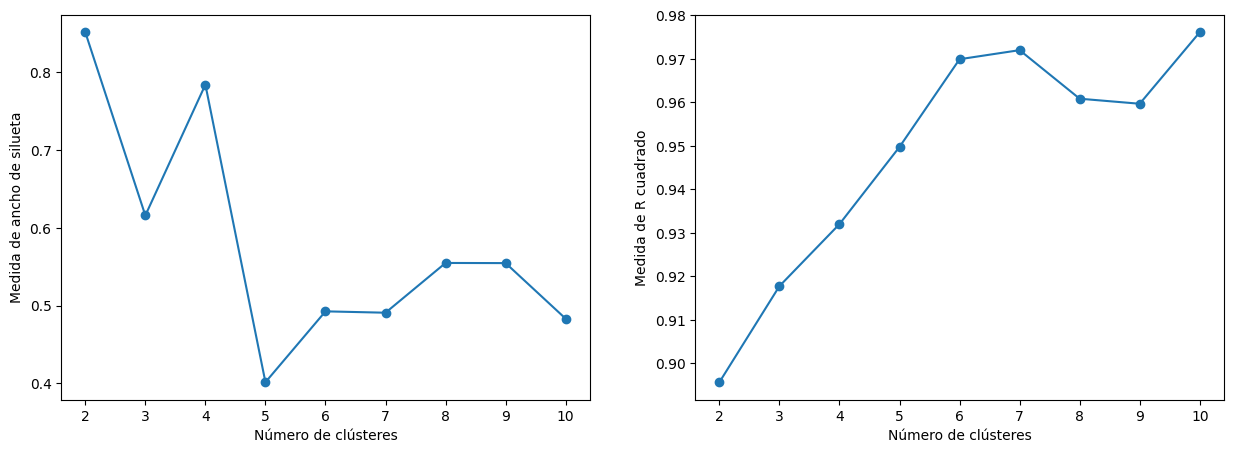

In [107]:
#METODO DEL CODO
# voy a probar para valores de k desde 2 al 11
rsilueta = np.zeros(9)
rrsquare = np.zeros(9)
for k in np.arange(2,11):
    cDx, Dyp,cDxIni = MyKMeansPlusPlus(Dx, k)
    rsilueta[k-2] = silhouette_score(Dx, Dyp)
    rrsquare[k-2] = medida_R_cuadrado(Dx, Dyp, cDx)

fig, ax = plt.subplots(1,2, figsize=(15,5))
ax[0].plot( np.arange(2,11),rsilueta, linestyle='-', marker='o')
ax[0].set_xlabel("Número de clústeres")
ax[0].set_ylabel("Medida de ancho de silueta")

ax[1].plot( np.arange(2,11),rrsquare, linestyle='-', marker='o')
ax[1].set_xlabel("Número de clústeres")
ax[1].set_ylabel("Medida de R cuadrado")

Redacte una conclusión que analice los gráficos del método del codo y del coeficiente de silueta (y/o R²) para la selección del número de clusters (k). Indique cuál es el valor óptimo de k y fundamente su elección con base en la interpretación de dichos gráficos.

Al analizar los gráficos el número óptimo de clústeres se elige buscando un equilibrio entre buena separación y capacidad explicativa no simplemente el valor máximo de uno de ellos

aunque k = 2 presenta la silueta más alta, su R² es baja, lo que indica una segmentación demasiado simple que no captura la variabilidad interna de los datos , k = 4 también muestra una silueta alta, pero la R² sigue aumentando de forma clara hasta k = 6, lo que evidencia la existencia de subestructuras adicionales relevantes además en k = 6 la silueta se mantiene alta y a partir de ahí cae bruscamente mientras que las mejoras en R² son marginales, señal de sobresegmentación, por lo que k = 6 representa el mejor compromiso entre calidad del agrupamiento y explicación de la variabilidad

## Métricas disponibles en KMeans de scikit-learn
El objeto KMeans de scikit-learn proporciona varias métricas y atributos importantes para evaluar el clustering:


Text(0, 0.5, 'Índice de Calinski-Harabasz')

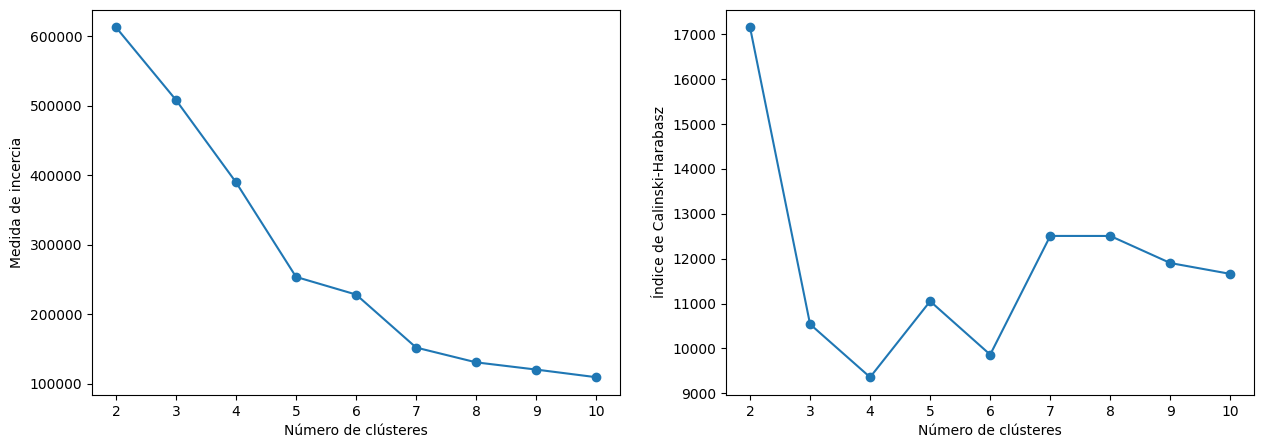

In [108]:
from sklearn.cluster import KMeans
from sklearn.metrics import calinski_harabasz_score

rincercia = np.zeros(9)
rcalinski = np.zeros(9)
for k in np.arange(2,11):
    kmeans = KMeans(n_clusters=k, random_state=42, n_init='auto')
    kmeans.fit(Dx)
    rincercia[k-2] =  kmeans.inertia_
    rcalinski[k-2] = calinski_harabasz_score(Dx, kmeans.labels_)

fig, ax = plt.subplots(1,2, figsize=(15,5))
ax[0].plot( np.arange(2,11),rincercia, linestyle='-', marker='o')
ax[0].set_xlabel("Número de clústeres")
ax[0].set_ylabel("Medida de incercia")

ax[1].plot(np.arange(2, 11), rcalinski, linestyle='-', marker='o')
ax[1].set_xlabel("Número de clústeres")
ax[1].set_ylabel("Índice de Calinski-Harabasz")

In [ ]:
# 2.3 Complete el codigo anterior para graficar el indice de calinski

Redacte una conclusión comparativa basada en el gráfico de inercia (método del codo) y el índice de Calinski-Harabasz. Determine el número óptimo de clusters (k) e interprete cómo cada métrica justifica dicha selección.

Con base en el análisis comparativo del gráfico de inercia (método del codo) y del índice de Calinski-Harabasz, se determina que el número óptimo de clústeres es k = 7
En el gráfico de inercia se observa que la reducción es muy pronunciada al aumentar k desde 2 hasta aproximadamente 7 lo que indica una mejora importante en la compacidad de los clústeres a partir de ese punto la disminución de la inercia es mucho más leve señalando rendimientos decrecientes y que añadir más clústeres no aporta una mejora significativa
Por su parte, el índice de Calinski-Harabasz, donde valores más altos representan una mejor separación entre clústeres y mayor cohesión interna, alcanza uno de sus valores más altos precisamente en k = 7 lo que confirma que en ese punto los grupos están bien definidos. En conjunto ambas métricas justifican la elección de k = 7 como un equilibrio adecuado entre calidad del agrupamiento y complejidad del modelo

# 🎯 **EJ 3: USA EL SIGUIENTE DATASET CON KMEANS++**
Cargue el dataset dataset_cuatro_separables_peque y realice el siguiente análisis de agrupamiento (clustering):

Determinación del k óptimo: Utilice el algoritmo k-means para calcular y graficar el método del codo con un rango de k razonable (por ejemplo, de 2 a 15 clusters).

Selección: Con base en los gráficos, justifique y seleccione el número óptimo de clusters (k_optimo).

Modelo final: Ajuste un modelo final de k-means utilizando el k_optimo.

Visualización: Visualice los resultados del agrupamiento y que los puntos estén coloreados según el cluster asignado. Incluya los centroides en la visualización.

✅ Dataset cargado desde URL GitHub


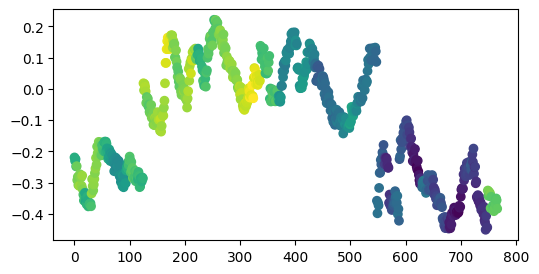

In [109]:
# Cargar dataset
D =cargar_dataset("dataset_cuatro_separables_peque.xlsx")
Dx = D[:,0:2]
Dy = D[:,2]
fig, ax = plt.subplots(figsize=(6,3))
ax.scatter(Dx[:,0],Dx[:,1], c=Dy)

Los centros iniciales elegidos aleatoriamente son:
[[ 7.12090096e+02 -2.88534124e-01]
 [ 8.39436204e+01 -2.84947135e-02]
 [ 4.62172171e+02  2.06620214e-01]
 [ 2.09655371e+02 -3.18159346e-01]]


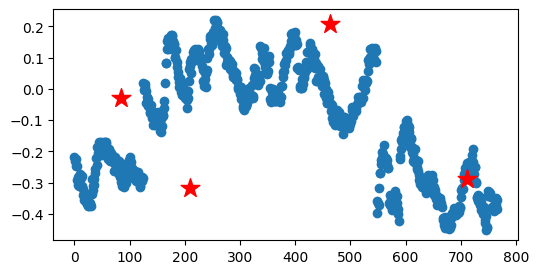

In [112]:
print('Los centros iniciales elegidos aleatoriamente son:')
K=4
cDx = paso1_elije_centros(K, Dx)
print(cDx)
fig, ax = plt.subplots(figsize=(6,3))
ax.scatter(Dx[:,0],Dx[:,1])
ax.scatter(cDx[:,0],cDx[:,1], marker='*', s=200, c='r')

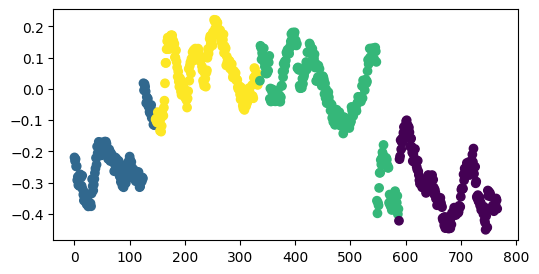

In [113]:
Dyp = paso2_asigna_puntos(Dx, cDx)
fig, ax = plt.subplots(figsize=(6,3))
ax.scatter(Dx[:,0],Dx[:,1], c=Dyp)

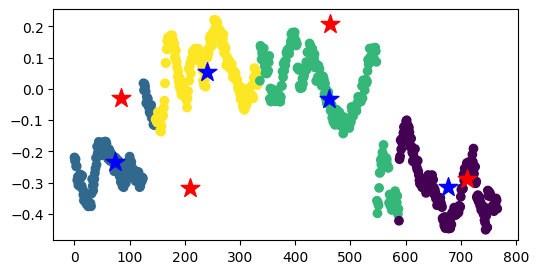

In [114]:
cDx_ant = cDx.copy()
cDx =paso3_actualiza_centros(Dx, cDx, Dyp, K)
fig, ax = plt.subplots(figsize=(6,3))
ax.scatter(Dx[:,0],Dx[:,1], c=Dyp)
ax.scatter(cDx[:,0],cDx[:,1], marker='*', s=200, c='b')
ax.scatter(cDx_ant[:,0],cDx_ant[:,1], marker='*', s=200, c='r')

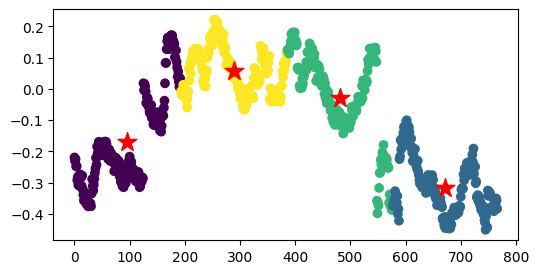

In [115]:
cDx, Dyp,cDxIni = MyKMeans(Dx, 4)
fig, ax = plt.subplots(figsize=(6,3))
ax.scatter(Dx[:,0],Dx[:,1], c=Dyp)
ax.scatter(cDx[:,0],cDx[:,1], marker='*', s=200, c='r')

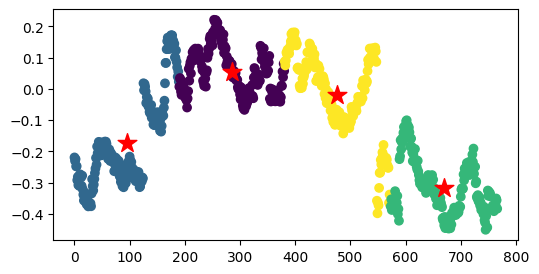

In [73]:
cDx, Dyp,cDxIni = MyKMeansPlusPlus(Dx, 4)
fig, ax = plt.subplots(figsize=(6,3))
ax.scatter(Dx[:,0],Dx[:,1], c=Dyp)
ax.scatter(cDx[:,0],cDx[:,1], marker='*', s=200, c='r')

Text(0, 0.5, 'Medida de R cuadrado')

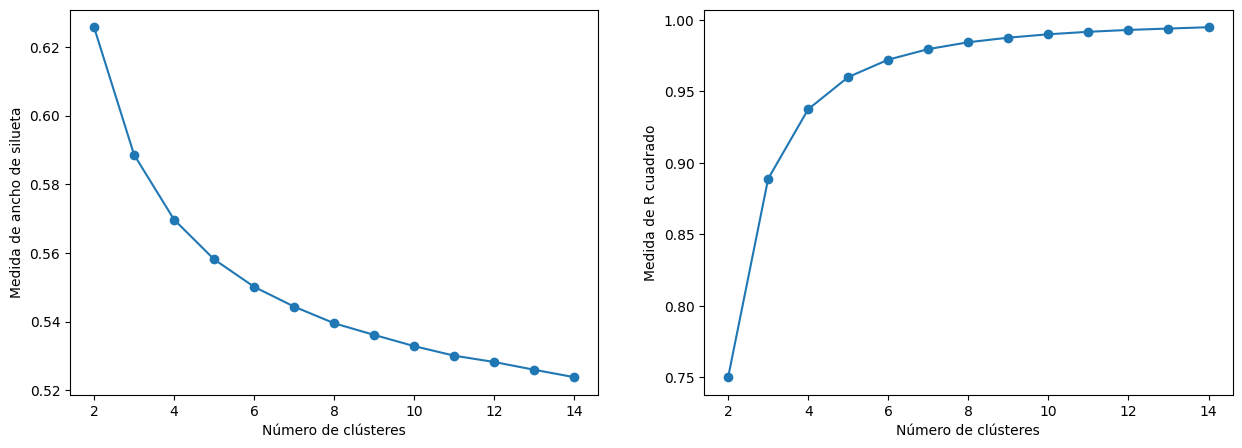

In [116]:
rsilueta = np.zeros(13)
rrsquare = np.zeros(13)
for k in np.arange(2,15):
    cDx, Dyp,cDxIni = MyKMeansPlusPlus(Dx, k)
    rsilueta[k-2] = silhouette_score(Dx, Dyp)
    rrsquare[k-2] = medida_R_cuadrado(Dx, Dyp, cDx)

fig, ax = plt.subplots(1,2, figsize=(15,5))
ax[0].plot( np.arange(2,15),rsilueta, linestyle='-', marker='o')
ax[0].set_xlabel("Número de clústeres")
ax[0].set_ylabel("Medida de ancho de silueta")

ax[1].plot( np.arange(2,15),rrsquare, linestyle='-', marker='o')
ax[1].set_xlabel("Número de clústeres")
ax[1].set_ylabel("Medida de R cuadrado")

Text(0, 0.5, 'Índice de Calinski-Harabasz')

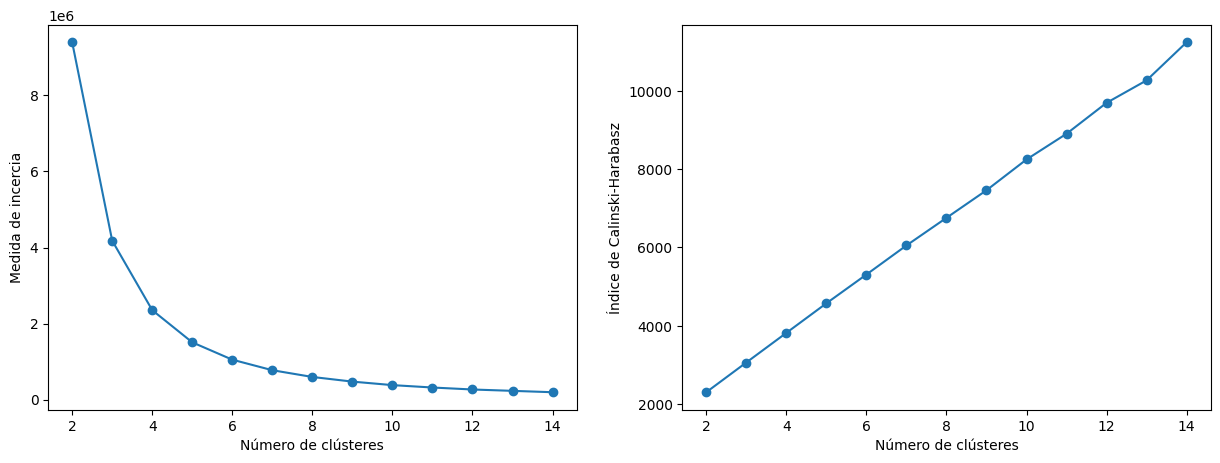

In [117]:
from sklearn.cluster import KMeans
from sklearn.metrics import calinski_harabasz_score

rincercia = np.zeros(13)
rcalinski = np.zeros(13)
for k in np.arange(2,15):
    kmeans = KMeans(n_clusters=k, random_state=42, n_init='auto')
    kmeans.fit(Dx)
    rincercia[k-2] =  kmeans.inertia_
    rcalinski[k-2] = calinski_harabasz_score(Dx, kmeans.labels_)

fig, ax = plt.subplots(1,2, figsize=(15,5))
ax[0].plot( np.arange(2,15),rincercia, linestyle='-', marker='o')
ax[0].set_xlabel("Número de clústeres")
ax[0].set_ylabel("Medida de incercia")

ax[1].plot(np.arange(2, 15), rcalinski, linestyle='-', marker='o')
ax[1].set_xlabel("Número de clústeres")
ax[1].set_ylabel("Índice de Calinski-Harabasz")

Considerando los cuatro gráficos, el número óptimo de clústeres se ubica alrededor de k = 6 o 7, ya que la medida de R² y el índice de Calinski-Harabasz muestran un crecimiento importante hasta ese punto indicando que se explica gran parte de la variabilidad y los clústeres están bien separados mientras tanto, el coeficiente de silueta decrece pero mantiene valores razonables hasta k = 6-7, y el gráfico de inercia muestra un codo que indica que agregar más clústeres después no mejora significativamente la compactación interna, por lo que esta selección representa el mejor equilibrio entre calidad de agrupamiento y complejidad del modelo

In [118]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

k_optimo = 6
kmeans_final = KMeans(n_clusters=k_optimo, random_state=42, init='k-means++')
kmeans_final.fit(Dx)

labels = kmeans_final.labels_
centroids = kmeans_final.cluster_centers_


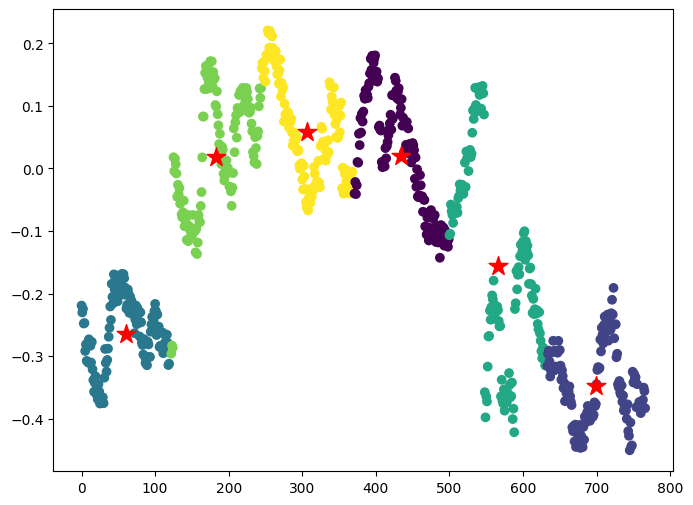

In [124]:
plt.figure(figsize=(8,6))
plt.scatter(Dx[:,0], Dx[:,1], c=labels)
plt.scatter(centroids[:,0], centroids[:,1], c='red', marker='*', s=200)


# 🚀 ¡TALLER FINALIZADO!"